# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). We will use this workspace to explore a smaller subset with Spark before deploying your cluster on the cloud.



In [1]:
# import libraries
import pyspark
import numpy as np
import seaborn as sns
import re
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType,StringType,DoubleType, LongType
from pyspark.sql.window import Window
from pyspark.sql.functions import  desc, explode, lit, split, udf,count, avg, col, concat\
,mean,when,lead,isnan,countDistinct,month,from_unixtime,datediff,to_timestamp
from pyspark.sql.functions import sum as Fsum
import pyspark.sql.functions as F
import pandas as pd
import scipy.stats as stats
import datetime
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


from pyspark.mllib.evaluation import MulticlassMetrics

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("CHURN") \
    .getOrCreate()

# Load and Clean Dataset
Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
df_pandasdf = pd.DataFrame(df.take(5), columns=df.columns)
df_pandasdf.head()

artist       auth firstName gender  itemInSession lastName  \
0    Martha Tilston  Logged In     Colin      M             50  Freeman   
1  Five Iron Frenzy  Logged In     Micah      M             79     Long   
2      Adam Lambert  Logged In     Colin      M             51  Freeman   
3            Enigma  Logged In     Micah      M             80     Long   
4         Daft Punk  Logged In     Colin      M             52  Freeman   

      length level                        location method      page  \
0  277.89016  paid                 Bakersfield, CA    PUT  NextSong   
1  236.09424  free  Boston-Cambridge-Newton, MA-NH    PUT  NextSong   
2  282.82730  paid                 Bakersfield, CA    PUT  NextSong   
3  262.71302  free  Boston-Cambridge-Newton, MA-NH    PUT  NextSong   
4  223.60771  paid                 Bakersfield, CA    PUT  NextSong   

    registration  sessionId                           song  status  \
0  1538173362000         29                      Rockpools     200   
1  1538331630000          8                         Canada     200   
2  1538173362000         29              Time For Miracles     200   
3  1538331630000          8    Knocking On Forbidden Doors     200   
4  1538173362000         29  Harder Better Faster Stronger     200   

              ts                                          userAgent userId  
0  1538352117000  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...     30  
1  1538352180000  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...      9  
2  1538352394000  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...     30  
3  1538352416000  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...      9  
4  1538352676000  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...     30

In [5]:
#Get overall statistics
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [8]:
#df.groupBy('firstName','lastName','level').count().show()

In [9]:
#df.groupBy('artist','userId','location').count().show()

In [6]:
#checking for invalid or missing data - for example, records without userids or sessionids.
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

In [7]:
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [8]:
df = df.filter(df["userId"] != "")

In [9]:
df.count()

278154

In [10]:
df.select('userId').distinct().count()

225

# Exploratory Data Analysis

### Define Churn
Use the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users.

### Explore Data
Once you've defined churn, we perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned.

In [11]:
#df.select('page').distinct().sort('page').show()

In [11]:
#Defining Churn using Cancel confirmation as defination
churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [12]:
df = df.withColumn("churn", churn_event("page"))

In [14]:
#df.filter(df.churn == 1).show()

In [13]:
#Defining users that Downgraded  using Submit downgrade as defination
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df = df.withColumn("downgraded", flag_downgrade_event("page"))
#df.printSchema()

In [14]:
#df.filter(df.downgraded==1).show()

In [15]:
#How many female users do we have in the data set?
df.filter(df.gender == 'F') \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .count()

104

In [16]:
#How many male users do we have in the data set?
df.filter(df.gender == 'M') \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .count()

121

In [17]:
#Statistics by Hour
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
df = df.withColumn("hour", get_hour(df.ts))
#hour_count = df.filter(df.page == "NextSong").groupby(df.hour).count().orderBy(df.hour.cast("float"))

songs_in_hour = df.filter(df.page == "NextSong").groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [16]:
songs_in_hour_pd = songs_in_hour.toPandas()


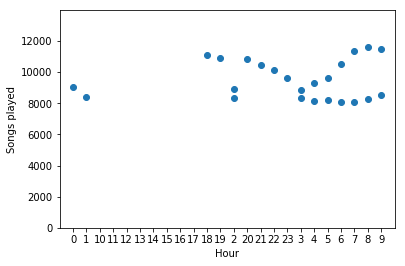

In [17]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on

In [18]:
user_df = df.groupBy('userId').agg(F.max('churn')).withColumnRenamed("max(churn)", "churn")
user_df.show()

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|    51|    1|
|   124|    0|
|     7|    0|
|    54|    1|
|    15|    0|
|   155|    0|
|   132|    0|
|   154|    0|
|100014|    1|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|    29|    1|
|    69|    0|
|100021|    1|
|    42|    0|
+------+-----+
only showing top 20 rows



Text(0.5,1,'churned')

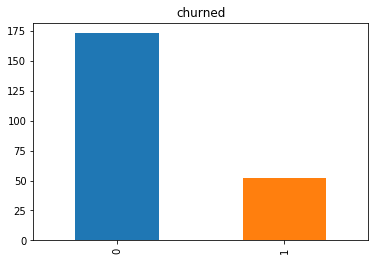

In [21]:
#Target Varaible (Churn) distribution
pd = user_df.select('churn').toPandas()
pd['churn'].value_counts().plot('bar').set_title('churned')


In [19]:
#artist count
artist_count = df.groupBy('userId').agg({'artist':'count'}).withColumnRenamed('count(artist)','artist_count')
user_df=user_df.join(artist_count, ['userId'])
#artist_count.show()

In [23]:
#a = user_df.select('artist_count').toPandas()
#b = user_df.select('churn').toPandas()

col1 = 'artist_count'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
a = pd[col1][pd[col2]==1]
b = pd[col1][pd[col2]==0]
print(stats.ttest_ind(a=a,b=b,equal_var=True))


Ttest_indResult(statistic=-2.3601519780787981, pvalue=0.01913005829224226)


Text(0.5,1,' not churned')

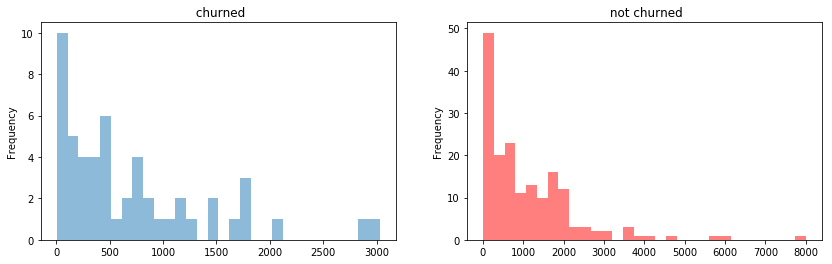

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'artist_count'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title(' churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title(' not churned')


In [20]:
# song count 
song_count = df.groupBy('userId').agg({'song':'count'}).withColumnRenamed('count(song)','song_count')
user_df=user_df.join(song_count, ['userId'])
#user_df=user_df.drop('song_count')
#user_df = user_df.drop('song_count')
#song_count.show()

#song count
#a = user_df.select('song_count').toPandas()
#b = user_df.select('churn').toPandas()
#pd = user_df.select(col1,col2).toPandas()
#col1 = 'song_count'
#col2 = 'churn'
#a = pd[col1][pd[col2]==1]
#b = pd[col1][pd[col2]==0]
#print(stats.ttest_ind(a=a,b=b,equal_var=True))



Text(0.5,1,' not churned')

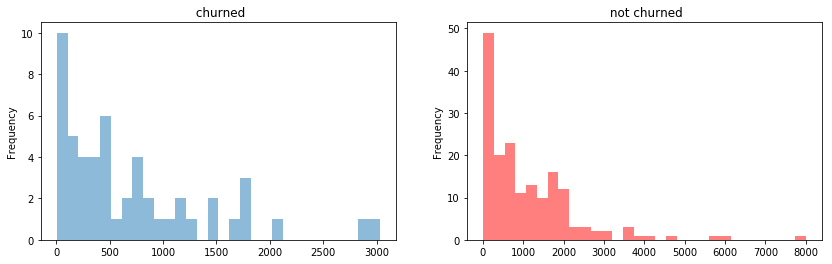

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'song_count'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title(' churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title(' not churned')


In [21]:
#user id counts that downgraded
downgrade_count = df.groupBy('userId').agg(F.sum('downgraded')).withColumnRenamed('sum(downgraded)','downgrade_count')
user_df=user_df.join(downgrade_count, ['userId'])
downgrade_count.describe().show()

+-------+------------------+------------------+
|summary|            userId|   downgrade_count|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|              0.28|
| stddev|105396.47791907164|0.5876709477736184|
|    min|                10|                 0|
|    max|                99|                 3|
+-------+------------------+------------------+



In [22]:
# Stats for total registration period of users
df_last_ts = df.select('userId','ts').groupby('userId').agg(F.max('ts'))
#df_last_ts.show()
df_registration_ts = df.select('userId','registration').groupby('userId').agg(F.min('registration'))
#df_registration_ts.show()
df_last_ts = df_last_ts.join(df_registration_ts,['userId'])
df_reg_length = df_last_ts.withColumn('total_reg_days',(col('max(ts)')-col('min(registration)'))/86400000)
#df_reg_length.show()
user_df=user_df.join(df_reg_length.select('userId','total_reg_days'), ['userId'])

In [32]:
col1 = 'total_reg_days'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
a = pd[col1][pd[col2]==1]
b = pd[col1][pd[col2]==0]
print(stats.ttest_ind(a=a,b=b,equal_var=True))


Ttest_indResult(statistic=-5.1999725267949124, pvalue=4.5041425910754789e-07)


Text(0.5,1,' not churned')

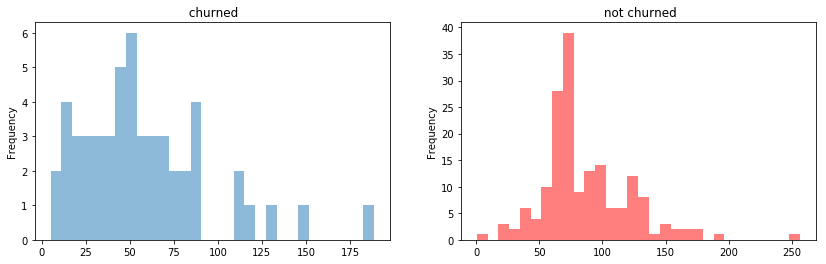

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'total_reg_days'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title(' churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title(' not churned')


In [23]:
#Gender
func_gender = udf(lambda x: 1 if x == 'F' else 0, IntegerType())
df = df.withColumn('func_gender',func_gender('gender'))
genderdf = df.groupBy('userId').agg(F.max('func_gender'))
user_df=user_df.join(genderdf, ['userId'])

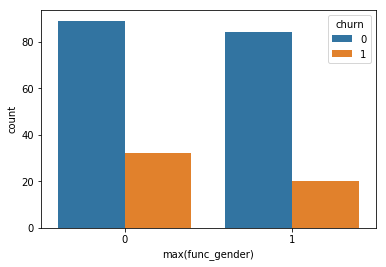

In [79]:
pd = user_df.select('userId','churn','max(func_gender)').toPandas()
sns.countplot(x = 'max(func_gender)',hue = 'churn',data = pd)

In [24]:
# length 
total_length = df.groupBy('userId').agg(F.sum('length')).withColumnRenamed('sum(length)','total_length')
user_df=user_df.join(total_length, ['userId'])

Text(0.5,1,' not churned')

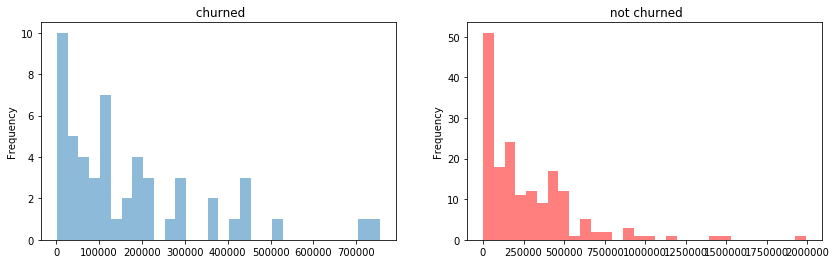

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'total_length'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title(' churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title(' not churned')


In [25]:
# sessions
session_count = df.groupBy('userId').agg(count('sessionId')).withColumnRenamed('count(sessionId)','session_count')
user_df=user_df.join(session_count, ['userId'])

Text(0.5,1,' not churned')

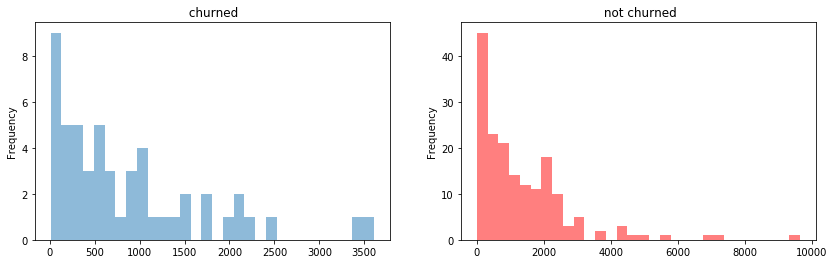

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'session_count'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title(' churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title(' not churned')


In [26]:
# level 
func_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
df = df.withColumn('func_level',func_level('level'))
leveldf = df.groupBy('userId').agg(F.max('func_level')).withColumnRenamed('max(func_level)','level')
user_df = user_df.join(leveldf,['userId'])
#user_df = user_df.drop('level')
#user_df = user_df.drop('level')
#user_df = user_df.drop('level')

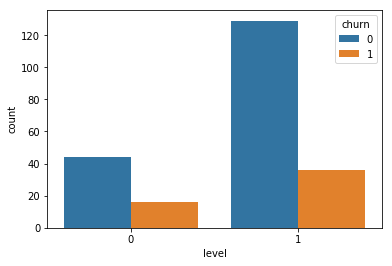

In [88]:
pd = user_df.select('userId','churn','level').toPandas()
sns.countplot(x = 'level',hue = 'churn',data = pd)

In [27]:
#df.select('page').distinct().show()
df_page=df.groupBy('userId').pivot('page').count().na.fill(0).drop('Cancellation Confirmation','Cancel','Error','Login',
                                                                   'Logout','NextSong','Settings',
                                                                  'Submit Downgrade','Submit Upgrade','Submit Registration','Downgrade',
                                                                   'Upgrade','Home','Help','Save Settings','About'
                                                                  )
df_page.show()

+------+----------+---------------+-----------+-----------+---------+
|userId|Add Friend|Add to Playlist|Roll Advert|Thumbs Down|Thumbs Up|
+------+----------+---------------+-----------+-----------+---------+
|200002|         4|              8|          7|          6|       21|
|100010|         4|              7|         52|          5|       17|
|   125|         0|              0|          1|          0|        0|
|    51|        28|             52|          0|         21|      100|
|   124|        74|            118|          4|         41|      171|
|     7|         1|              5|         16|          1|        7|
|    54|        33|             72|         47|         29|      163|
|    15|        31|             59|          1|         14|       81|
|   155|        11|             24|          8|          3|       58|
|   132|        41|             38|          2|         17|       96|
|100014|         6|              7|          2|          3|       17|
|   154|         3| 

In [28]:
thumbsdown_count = df_page.groupBy('userId').agg(F.sum('Thumbs Down')).withColumnRenamed('sum(Thumbs Down)','thumbsdown_count')
#thumbsup_count.show()
user_df=user_df.join(thumbsdown_count, ['userId'])
#a = user_df.select('thumbsdown_count').toPandas()
#b = user_df.select('churn').toPandas()
col2= 'thumbsdown_count'
col1= 'churn'
pd = user_df.select(col1,col2).toPandas()
a = pd[col1][pd[col2]==1]
b = pd[col1][pd[col2]==0]
#print(a)
#print(b)
print(stats.ttest_ind(a=a,b=b,equal_var=True))
#pd = user_df.select('userId','churn','thumbsdown_count').toPandas()
#sns.countplot(x = 'thumbsdown_count',hue = 'churn',data = pd)

Ttest_indResult(statistic=1.3513278493843528, pvalue=0.18382481091003941)


Text(0.5,1,'Thumbs Down not churned')

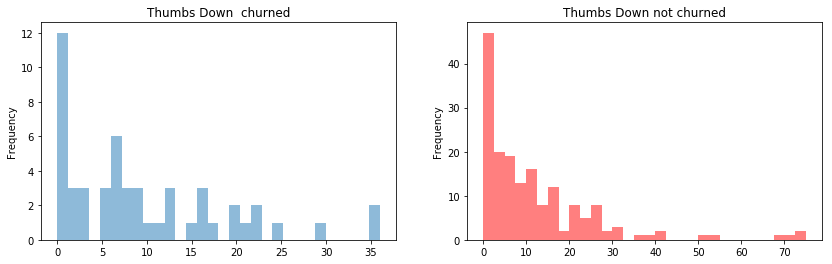

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'thumbsdown_count'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title('Thumbs Down  churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title('Thumbs Down not churned')


In [29]:
addtoplaylist_count = df_page.groupBy('userId').agg(F.sum('Add to Playlist')).withColumnRenamed('sum(Add to Playlist)','addtoplaylist_count')

user_df=user_df.join(addtoplaylist_count, ['userId'])
#user_df=user_df.drop('sum(Add to Playlist)')
#user_df=user_df.drop('sum(Add to Playlist)')
#user_df=user_df.drop('sum(Add to Playlist)')
#user_df=user_df.drop('sum(Add to Playlist)')
user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- artist_count: long (nullable = false)
 |-- song_count: long (nullable = false)
 |-- downgrade_count: long (nullable = true)
 |-- total_reg_days: double (nullable = true)
 |-- max(func_gender): integer (nullable = true)
 |-- total_length: double (nullable = true)
 |-- session_count: long (nullable = false)
 |-- level: integer (nullable = true)
 |-- thumbsdown_count: long (nullable = true)
 |-- addtoplaylist_count: long (nullable = true)



Text(0.5,1,' not churned')

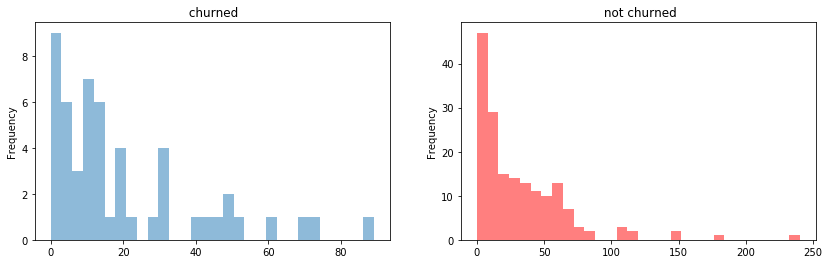

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'addtoplaylist_count'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title(' churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title(' not churned')



In [30]:
addfriend_count = df_page.groupBy('userId').agg(F.sum('Add Friend')).withColumnRenamed('sum(Add Friend)','addfriend_count')
#thumbsup_count.show()
user_df=user_df.join(addfriend_count, ['userId'])
col2= 'addfriend_count'
col1= 'churn'
pd = user_df.select(col1,col2).toPandas()
a = pd[col1][pd[col2]==1]
b = pd[col1][pd[col2]==0]
print(stats.ttest_ind(a=a,b=b,equal_var=True))

Ttest_indResult(statistic=-0.81950859734491988, pvalue=0.42024081945361502)


Text(0.5,1,' not churned')

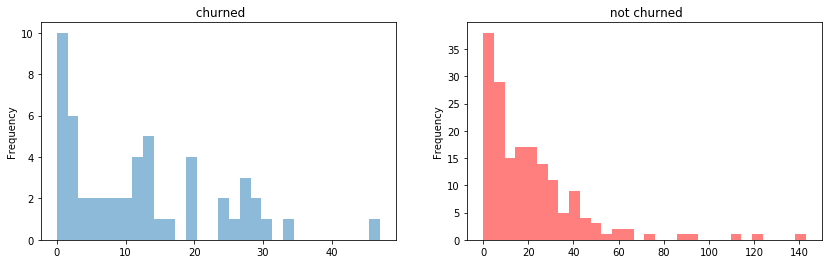

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'addfriend_count'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title(' churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title(' not churned')


In [31]:
rolladvert_count = df_page.groupBy('userId').agg(F.sum('Roll Advert')).withColumnRenamed('sum(Roll Advert)','rolladvert_count')
#thumbsup_count.show()
user_df=user_df.join(rolladvert_count, ['userId'])
#user_df=user_df.drop('rolladvert_count')
col2= 'rolladvert_count'
col1= 'churn'
pd = user_df.select(col1,col2).toPandas()
a = pd[col1][pd[col2]==1]
b = pd[col1][pd[col2]==0]
#print(a)
#print(b)
print(stats.ttest_ind(a=a,b=b,equal_var=True))


Ttest_indResult(statistic=0.46987149389936472, pvalue=0.64144667827912882)


Text(0.5,1,' not churned')

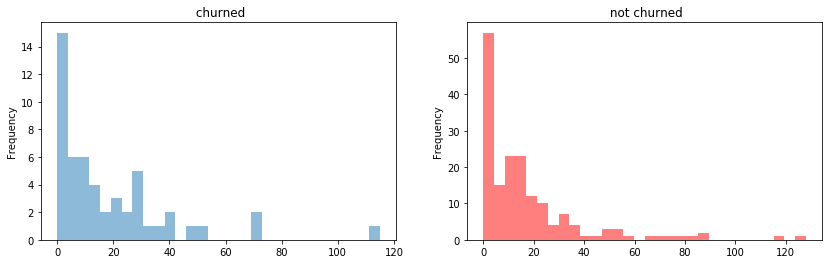

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'rolladvert_count'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title(' churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title(' not churned')


In [32]:

thumbsup_count = df_page.groupBy('userId').agg(F.sum('Thumbs Up')).withColumnRenamed('sum(Thumbs Up)','thumbsup_count')
#thumbsup_count.show()
user_df=user_df.join(thumbsup_count, ['userId'])
#user_df=user_df.drop('thumbsup_count')
#a = user_df.select('thumbsup_count').toPandas()
#b = user_df.select('churn').toPandas()
col1= 'thumbsup_count'
col2= 'churn'
pd = user_df.select(col1,col2).toPandas()
a = pd[col1][pd[col2]==1]
b = pd[col1][pd[col2]==0]
print(stats.ttest_ind(a=a,b=b,equal_var=True))


Ttest_indResult(statistic=-2.5465799259653137, pvalue=0.011552536742223812)


Text(0.5,1,' not churned')

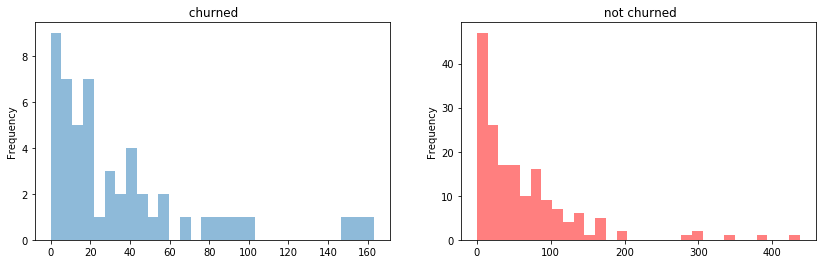

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'thumbsup_count'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title(' churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title(' not churned')


In [33]:
#user_df = user_df.drop('max(int_gender)','level: integer')
user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- artist_count: long (nullable = false)
 |-- song_count: long (nullable = false)
 |-- downgrade_count: long (nullable = true)
 |-- total_reg_days: double (nullable = true)
 |-- max(func_gender): integer (nullable = true)
 |-- total_length: double (nullable = true)
 |-- session_count: long (nullable = false)
 |-- level: integer (nullable = true)
 |-- thumbsdown_count: long (nullable = true)
 |-- addtoplaylist_count: long (nullable = true)
 |-- addfriend_count: long (nullable = true)
 |-- rolladvert_count: long (nullable = true)
 |-- thumbsup_count: long (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset,we can use F1 score as the metric to optimize.

In [34]:
user_df = user_df.drop('userId')
features = [col for col in user_df.columns if col!='churn'] 
train, test = user_df.randomSplit([0.7, 0.3], seed=42)

In [40]:
def pipeline(classifier, params):
    
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=params,
        evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=2,
    )
    return model

In [43]:
classfr = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
classfr_param = ParamGridBuilder().build()
lr = pipeline(classfr, classfr_param)

In [44]:
fit_lr = lr.fit(train)

In [45]:
predictions = fit_lr.transform(test)


In [48]:
predictions.select("prediction").dropDuplicates().collect()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("f1 using Logistic Regression: {}".format(f1_score))

f1 using Logistic Regression: 0.7285980148883375


In [49]:
#Random Forest
classifier_RF = RandomForestClassifier(featuresCol="scaled_features", labelCol="churn")
classifier_RF_param = ParamGridBuilder().build()
RF = pipeline(classifier_RF, classifier_RF_param)

In [50]:
fit_RF = RF.fit(train)

In [51]:
predictions_RF = fit_RF.transform(test)

In [63]:
predictions_RF.select("prediction").dropDuplicates().collect()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
f1_score = evaluator.evaluate(predictions_RF, {evaluator.metricName: "f1"})
print("f1 using RandomForest : {}".format(f1_score))

f1 using RandomForest : 0.7406095884873475


In [58]:
#HYPERPARAMETER TUNING
RF_tune = RandomForestClassifier(featuresCol="scaled_features", labelCol="churn")
paramGrid_RF = ParamGridBuilder() \
    .addGrid(RF_tune.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(RF_tune.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()
tuned_model = pipeline(RF_tune, paramGrid_RF)

In [59]:
fit_tuned_model = tuned_model.fit(train)                                       
final_model = fit_tuned_model.bestModel
predictions_final_model_ = final_model.transform(test)

In [60]:
evaluator_best = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
best_f1_score = evaluator_best.evaluate(predictions_final_model_, {evaluator.metricName: "f1"})
print("f1 using tuned RF: {}".format(best_f1_score))

f1 using tuned RF: 0.7545523690215203


In [96]:
"""
cols = user_df.columns
features = [col for col in user_df.columns if col!='churn'] 
print(features)
stages = []
#user_df = user_df.withColumn("userID", user_df["userID"].cast(IntegerType()))
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
user_df = user_df.withColumn("churn", user_df["churn"].cast(StringType()))
label_Indx = StringIndexer(inputCol = 'churn', outputCol = 'label')
stages += [label_Indx]
assembler = VectorAssembler(inputCols=features, outputCol="features")
stages += [assembler]
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
stages += [scaler]
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(user_df)
user_df = pipelineModel.transform(user_df)
selectedCols = ['label', 'features'] + cols
user_df = user_df.select(selectedCols)
user_df.printSchema()
train, test = user_df.randomSplit([0.7, 0.3], seed=42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
predictions.select('rawPrediction', 'prediction', 'probability').show(10)
results = predictions.select(['prediction', 'label'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)
cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])
print("Logistic RegressionClassifier: accuracy,precision,recall",accuracy,precision,recall)
rf = RandomForestClassifier(labelCol='label', featuresCol='features')
rfModel = rf.fit(train)
predictionsrf = rfModel.transform(test)
resultsrf = predictionsrf.select(['prediction', 'label'])
predictionAndLabelsrf=resultsrf.rdd
metricsrf = MulticlassMetrics(predictionAndLabelsrf)
cm=metricsrf.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])
print("Random Forest Classifier: accuracy,precision,recall",accuracy,precision,recall)
trainingSummary = fit_tuned_model.summary
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
"""

['userID', 'artist_count', 'song_count', 'downgrade_count', 'total_reg_days', 'total_length', 'session_count', 'thumbsdown_count', 'addtoplaylist_count', 'addfriend_count', 'rolladvert_count', 'thumbsup_count', 'max(func_gender)', 'level']
